# ESM 237: Climate Impact - Homework 2

**Authors**: 
Matilde Saucedo, Julia Field, Kat Le

For this assignment, we'll access CMIP6 data through their Amazon S3 bucket using Python. This notebook will show the code used to create the figures for our HW2 report.

### Region of interest
In this analysis, we want to look at the Great Lakes Basin region located in Canada and the US.

### Research Question
Lakes are sentinels of climate change.  Understanding how climate change, particularly temperature variations, will affect lake regions is crucial because these water bodies serve as valuable indicators of broader environmental shifts through measurable changes in their physical, chemical, and biological characteristics.

- What is the historical and projected climate in the Great Lakes Basin under different pathways (SSP 2-4.5 and SSP 5-8.5)?
- How are climate trends changing over time? What direction are they changing, and is the change statistically signficant?


### Set up

In [1]:
# Import necessary packages
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import intake
import s3fs
import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as ctx
from shapely.geometry import box
import pymannkendall as mk
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Point

### Map of Region

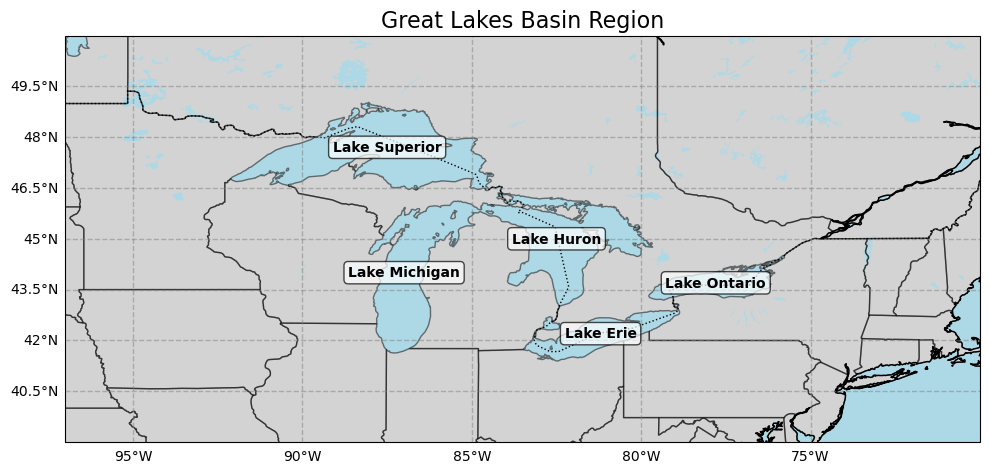

In [2]:
# Define min/max bounds for region of interest (Great Lakes region)
lat_min, lat_max = 39.0, 51.0
lon_min, lon_max = 263.0, 290.0

# Convert longitude to standard -180 to 180 format
lon_min_std = lon_min - 360 if lon_min > 180 else lon_min
lon_max_std = lon_max - 360 if lon_max > 180 else lon_max

# Create a figure and axes with Plate Carree projection
plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set extent to our region of interest
ax.set_extent([lon_min_std, lon_max_std, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add natural earth features for a detailed basemap
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.LAKES, facecolor='lightblue')

# Add country borders, states, and coastlines for additional detail
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, alpha=0.5)
ax.add_feature(cfeature.COASTLINE)

# Add gridlines
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Define Great Lakes coordinates (longitude, latitude)
great_lakes = {
    'Lake Superior': (-87.5, 47.7),
    'Lake Michigan': (-87.0, 44.0),
    'Lake Huron': (-82.5, 45.0),
    'Lake Erie': (-81.2, 42.2),
    'Lake Ontario': (-77.8, 43.7)
}

# Add labels for each Great Lake
for lake_name, (lon, lat) in great_lakes.items():
    plt.text(lon, lat, lake_name, fontsize=10, fontweight='bold', 
             ha='center', va='center', transform=ccrs.PlateCarree(),
             bbox=dict(facecolor='white', alpha=0.7, boxstyle='round'))

# Add title
plt.title('Great Lakes Basin Region', fontsize=16)

# Show the plot
plt.tight_layout()
plt.show()

### Load CMIP6 catalog stored on AWS

In [3]:
# Open the CMIP6 data catalog, store as a variable
catalog = intake.open_esm_datastore('https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json')

### Explore catalog

The following code searches the catalog for historical, ssp2-4.5, and ssp5-8.5 CMIP data for ensemble, r1i1p1f1.

In [4]:
# Search through catalog, find all simulations
res = catalog.search(activity_id=['ScenarioMIP', 'CMIP'], 
                     experiment_id=['historical' , 'ssp245', 'ssp585'], 
                     member_id="r1i1p1f1")

# Convert to a data frame
res_df = res.df

# Get unique model names in the set of search results
models = res_df.source_id.unique()

# Print list of model names
print(models)

['GFDL-CM4' 'GFDL-ESM4' 'IPSL-CM6A-LR' 'GISS-E2-1-G' 'BCC-CSM2-MR'
 'BCC-ESM1' 'MIROC6' 'AWI-CM-1-1-MR' 'MRI-ESM2-0' 'CESM2-WACCM' 'CanESM5'
 'CESM2' 'SAM0-UNICON' 'GISS-E2-1-H' 'INM-CM4-8' 'EC-Earth3-Veg'
 'INM-CM5-0' 'MPI-ESM-1-2-HAM' 'EC-Earth3' 'NESM3' 'CAMS-CSM1-0'
 'MPI-ESM1-2-LR' 'MPI-ESM1-2-HR' 'MCM-UA-1-0' 'NorESM2-LM'
 'GISS-E2-1-G-CC' 'FGOALS-g3' 'FGOALS-f3-L' 'E3SM-1-0' 'KACE-1-0-G'
 'NorCPM1' 'KIOST-ESM' 'NorESM2-MM' 'ACCESS-CM2' 'FIO-ESM-2-0'
 'ACCESS-ESM1-5' 'CESM2-FV2' 'CESM2-WACCM-FV2' 'GISS-E2-2-H' 'E3SM-1-1'
 'IITM-ESM' 'CIESM' 'E3SM-1-1-ECA' 'AWI-ESM-1-1-LR' 'EC-Earth3-Veg-LR'
 'TaiESM1' 'CAS-ESM2-0' 'CMCC-CM2-SR5' 'EC-Earth3-AerChem'
 'IPSL-CM5A2-INCA' 'CMCC-CM2-HR4' 'EC-Earth3-CC' 'CMCC-ESM2' 'ICON-ESM-LR'
 'IPSL-CM6A-LR-INCA']


The output above shows all models available.. We'll choose 'MIROC6', 'CESM2', 'CanESM5'.


'CESM2' = US model, strong representation of biogeochemical and atmospherice processes

'CanESM5' = Canadian model, strong representation of carbon cycle processes

MIROC6 - Japanese model, good predictive ability for precipitation

https://www.sciencedirect.com/science/article/pii/S2666592124000532

In [5]:
# Specify search terms to query catalog for CanESM5 data
# activity_id: which project do you want? CMIP = historical data, ScenarioMIP = future projections
activity_ids = ['ScenarioMIP', 'CMIP'] 

# source_id: which model do you want? 
source_id = ['MIROC6', 'CESM2', 'CanESM5']

# experiment_id: what experimental configuration do you want? 
experiment_ids = ['historical', 'ssp245', 'ssp585']

# member_id: which ensemble member do you want? 
member_id = 'r10i1p1f1'

# table_id: which part of the Earth system and time resolution do you want? Here we want monthly atmosphere data
table_id = 'Amon' 

# variable_id: which climate variable do you want? Here we want surface air temperature
variable_id = 'tas' 

In [6]:
res = catalog.search(activity_id=activity_ids, 
                     source_id=source_id, 
                     experiment_id=experiment_ids, 
                     member_id=member_id, 
                     table_id=table_id, 
                     variable_id=variable_id)


### Check data that was downloaded

In [7]:
# Sort data frame by source_id 
res_sorted = res.df.sort_values(by='source_id')

# Display the sorted DataFrame
display(res_sorted)

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
1,CMIP,NCAR,CESM2,historical,r10i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/CMIP/NCAR/CESM2/historica...,NaN,20190313
5,ScenarioMIP,NCAR,CESM2,ssp245,r10i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/NCAR/CESM2/ss...,NaN,20200528
6,ScenarioMIP,NCAR,CESM2,ssp585,r10i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/NCAR/CESM2/ss...,NaN,20200528
2,CMIP,CCCma,CanESM5,historical,r10i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/CMIP/CCCma/CanESM5/histor...,NaN,20190429
3,ScenarioMIP,CCCma,CanESM5,ssp585,r10i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/CCCma/CanESM5...,NaN,20190429
4,ScenarioMIP,CCCma,CanESM5,ssp245,r10i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/CCCma/CanESM5...,NaN,20190429
0,CMIP,MIROC,MIROC6,historical,r10i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/CMIP/MIROC/MIROC6/histori...,NaN,20181212
7,ScenarioMIP,MIROC,MIROC6,ssp585,r10i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/MIROC/MIROC6/...,NaN,20200623
8,ScenarioMIP,MIROC,MIROC6,ssp245,r10i1p1f1,Amon,tas,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/MIROC/MIROC6/...,NaN,20200623


### Download historical and SSP scenarios for each model from AWS.

In [8]:
# Extract data for the historical period, store as a separate xarray Dataset
hist_data_canesm5 = xr.open_zarr(res.df['zstore'][2], storage_options={'anon': True}).assign_coords(scenario="historical", model = "canesm5")
hist_data_cesm2 = xr.open_zarr(res.df['zstore'][1], storage_options={'anon': True}).assign_coords(scenario="historical", model = "cesm2")
hist_data_miroc6 = xr.open_zarr(res.df['zstore'][0], storage_options={'anon': True}).assign_coords(scenario="historical", model = "miroc6")

# Extract data for ssp245, store as a separate xarray Dataset
ssp245_data_canesm5 = xr.open_zarr(res.df['zstore'][4], storage_options={'anon': True}).assign_coords(scenario="ssp245", model="canesm5")
ssp245_data_cesm2 = xr.open_zarr(res.df['zstore'][5], storage_options={'anon': True}).assign_coords(scenario="ssp245", model="cesm2")
ssp245_data_miroc6 = xr.open_zarr(res.df['zstore'][8], storage_options={'anon': True}).assign_coords(scenario="ssp245", model="miroc6")

# Extract data for ssp585, store as a separate xarray Dataset
ssp585_data_canesm5 = xr.open_zarr(res.df['zstore'][3], storage_options={'anon': True}).assign_coords(scenario="ssp585", model="canesm5")
ssp585_data_cesm2 = xr.open_zarr(res.df['zstore'][6], storage_options={'anon': True}).assign_coords(scenario="ssp585", model="cesm2")
ssp585_data_miroc6 = xr.open_zarr(res.df['zstore'][7], storage_options={'anon': True}).assign_coords(scenario="ssp585", model="miroc6")

### Combine and convert to Farenheit

In [9]:
# Combine all scenarios for CanESM5
canesm5_combined = xr.concat([hist_data_canesm5, ssp245_data_canesm5, ssp585_data_canesm5], 
                             dim='time')
# Convert from Kelvin to Fahrenheit
canesm5_combined['tas_fahrenheit'] = (canesm5_combined['tas'] - 273.15) * 9/5 + 32

# Combine all scenarios for CESM2
cesm2_combined = xr.concat([hist_data_cesm2, ssp245_data_cesm2, ssp585_data_cesm2], 
                           dim="time")

# Convert from Kelvin to Fahrenheit
cesm2_combined['tas_fahrenheit'] = (cesm2_combined['tas'] - 273.15) * 9/5 + 32

# Combine all scenarios for MIROC6
miroc6_combined = xr.concat([hist_data_miroc6, ssp245_data_miroc6, ssp585_data_miroc6], 
                            dim="time")

# Convert from Kelvin to Fahrenheit
miroc6_combined['tas_fahrenheit'] = (miroc6_combined['tas'] - 273.15) * 9/5 + 32

### Slice to region of interest (Great Lakes Region)

In [10]:
# Define min/max bounds for region of interest (Great Lakes region)
lat_min, lat_max = 39.0, 51.0
lon_min, lon_max = 263.0, 290.0

# Clip CanESM5 data to Great Lakes region
canesm5_gl = canesm5_combined.sel(lat=slice(lat_min, lat_max), 
                                  lon=slice(lon_min, lon_max))

# Clip CESM2 data to Great Lakes region
cesm2_gl = cesm2_combined.sel(lat=slice(lat_min, lat_max), 
                              lon=slice(lon_min, lon_max))

# Clip MIROC6 data to Great Lakes region
miroc6_gl = miroc6_combined.sel(lat=slice(lat_min, lat_max), 
                                lon=slice(lon_min, lon_max))

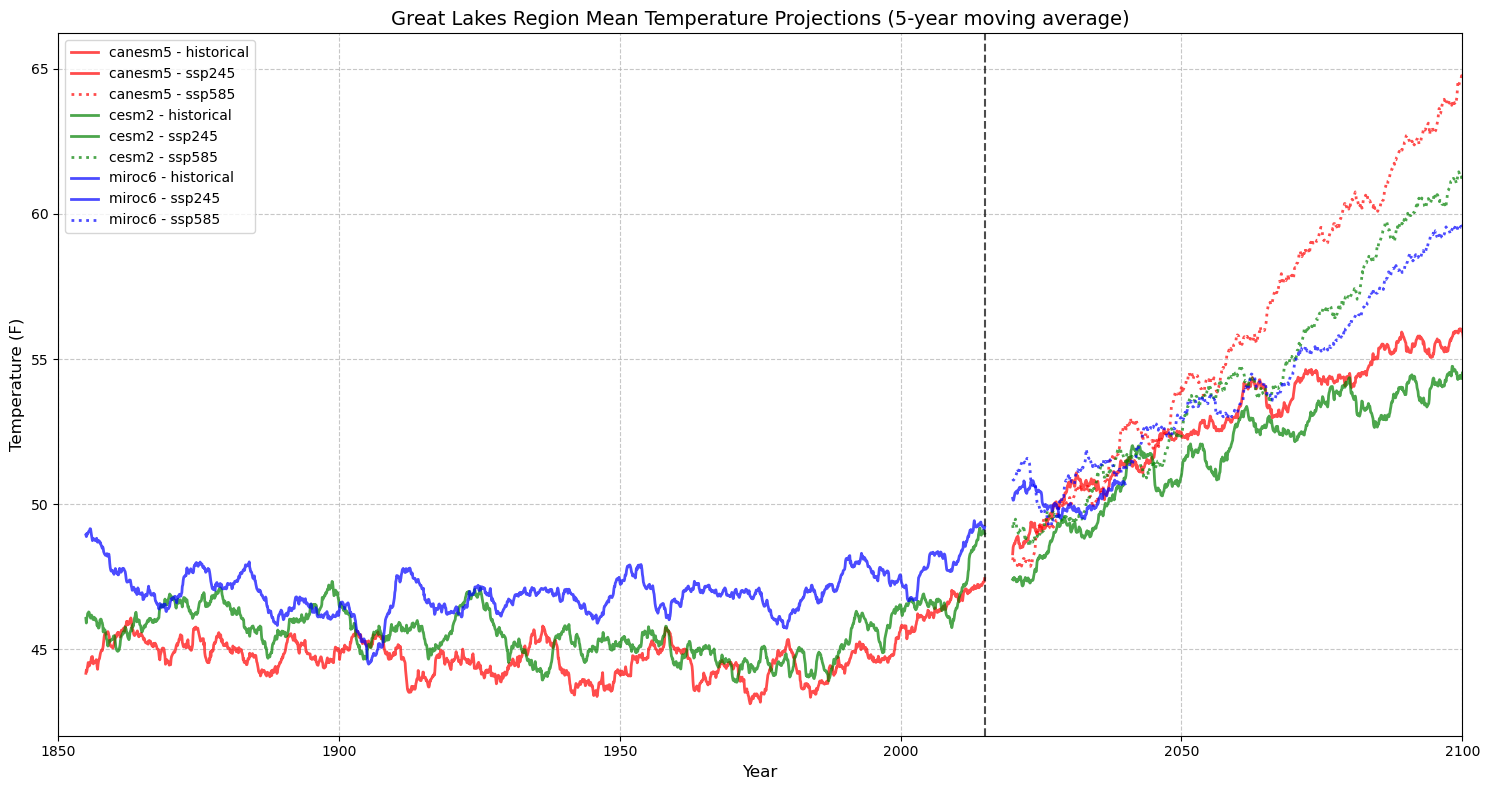

In [11]:
# Create figure and define styles
fig, ax = plt.subplots(figsize=(15, 8))
model_colors = {'canesm5': 'red', 'cesm2': 'green', 'miroc6': 'blue'}
scenario_styles = {'historical': 'solid', 'ssp245': 'solid', 'ssp585': 'dotted'}
window_size = 60

# Process and plot all models
for model_name, model_data in {'canesm5': canesm5_gl, 'cesm2': cesm2_gl, 'miroc6': miroc6_gl}.items():
    for scenario in np.unique(model_data.scenario.values):
        # Get data for this scenario
        scenario_mask = model_data.scenario == scenario
        scenario_data = model_data.tas_fahrenheit.where(scenario_mask, drop=True)
        time_values = model_data.time.where(scenario_mask, drop=True).values
        
        # Calculate regional mean and convert time
        regional_mean = scenario_data.mean(dim=['lat', 'lon']).compute().values
        years = np.array([pd.Timestamp(t).year + (pd.Timestamp(t).month-1)/12 + pd.Timestamp(t).day/365 
                           if not hasattr(t, 'year') else t.year + (t.month-1)/12 + t.day/365 for t in time_values])
        
        # Apply moving average and plot
        if len(regional_mean) > window_size:
            # Calculate running mean
            cumsum = np.cumsum(np.insert(regional_mean, 0, 0))
            smoothed_data = (cumsum[window_size:] - cumsum[:-window_size]) / window_size
            
            # Plot
            ax.plot(years[window_size-1:], smoothed_data, 
                    color=model_colors[model_name], linestyle=scenario_styles[scenario],
                    linewidth=2.0, alpha=0.7, label=f"{model_name} - {scenario}")

# Configure and display plot
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Temperature (F)', fontsize=12)
ax.set_title('Great Lakes Region Mean Temperature Projections (5-year moving average)', fontsize=14)
ax.legend(fontsize=10, loc='upper left')
ax.grid(True, linestyle='--', alpha=0.7)
ax.set_xlim(1850, 2100)
ax.axvline(x=2015, color='black', linestyle='--', alpha=0.7, label='2015')
plt.tight_layout()
plt.show()

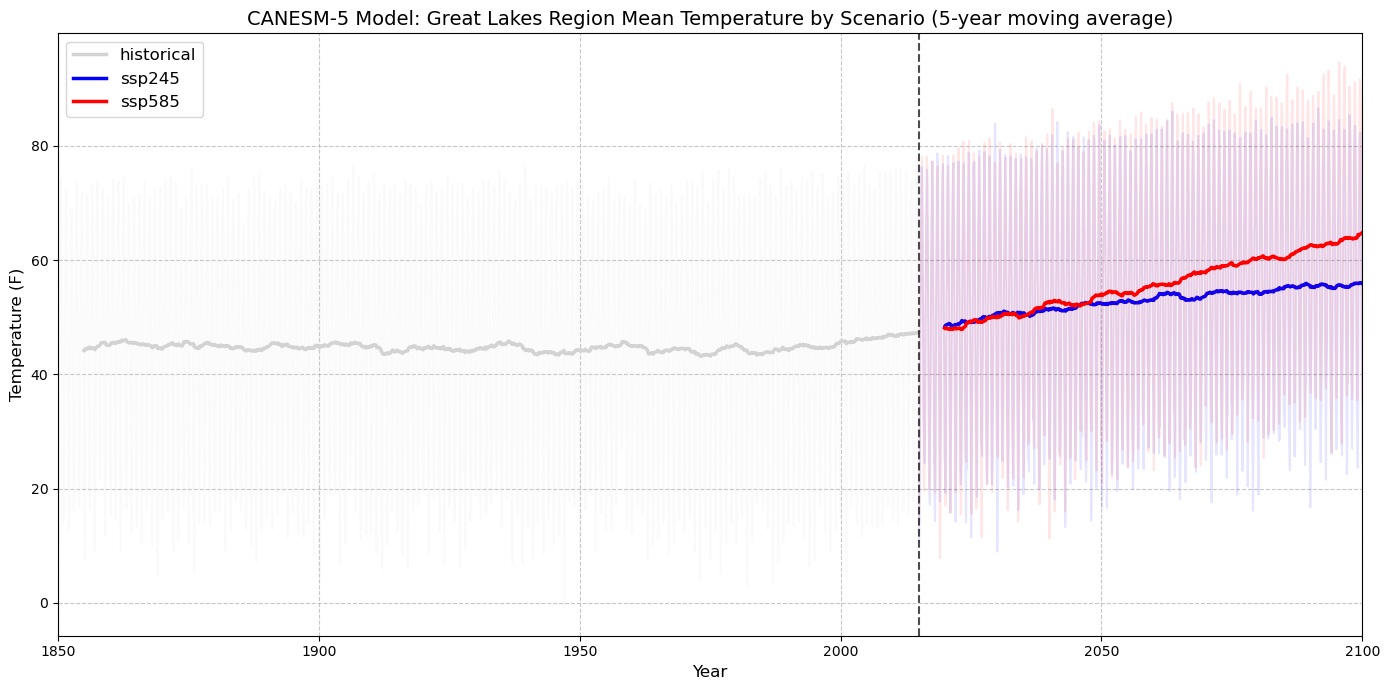

In [12]:
# Function to calculate running mean
def running_mean(data, window):
    return np.convolve(data, np.ones(window)/window, mode='valid')

# Create scenarios list
scenarios = ['historical', 'ssp245', 'ssp585']
colors = {'historical': 'lightgrey', 'ssp245': 'blue', 'ssp585': 'red'}

# Create a figure for the Great Lakes region with smoother curves
fig, ax = plt.subplots(figsize=(14, 7))

# Process and plot each scenario
for scenario in scenarios:
    # Create a mask for this scenario
    scenario_mask = canesm5_gl.scenario == scenario
    
    # Apply the mask to get data for this scenario only
    scenario_data = canesm5_gl.tas_fahrenheit.where(scenario_mask, drop=True)
    
    # Calculate regional mean (across lat/lon) for each time point
    regional_mean = scenario_data.mean(dim=['lat', 'lon']).compute()
    
    # Get the time values for this scenario
    time_values = canesm5_gl.time.where(scenario_mask, drop=True).values
    
    # Extract years as numeric values for plotting
    years = np.array([t.year + (t.month-1)/12 + t.day/365 for t in time_values])
    
    # Apply 5-year (60-month) moving average to smooth the data
    window_size = 60
    if len(regional_mean) > window_size:
        smoothed_data = running_mean(regional_mean.values, window_size)
        smoothed_years = years[window_size-1:]
        
        # Plot both the raw (transparent) and smoothed data
        ax.plot(years, regional_mean.values, color=colors[scenario], alpha=0.1)
        ax.plot(smoothed_years, smoothed_data, 
                color=colors[scenario], 
                linewidth=2.5,
                label=f"{scenario}")
    else:
        # If not enough data points for smoothing, just plot raw data
        ax.plot(years, regional_mean.values, 
                color=colors[scenario], 
                linewidth=2.5,
                label=scenario)

# Add labels and title
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Temperature (F)', fontsize=12)
ax.set_title('CANESM-5 Model: Great Lakes Region Mean Temperature by Scenario (5-year moving average)', fontsize=14)
ax.legend(fontsize=12)
ax.grid(True, linestyle='--', alpha=0.7)

# Set appropriate x-axis limits
plt.xlim(1850, 2100)

# Highlight the transition between historical and future periods (around 2015)
plt.axvline(x=2015, color='black', linestyle='--', alpha=0.7, 
            label='Historical to future transition')

# Show the plot
plt.tight_layout()
plt.show()

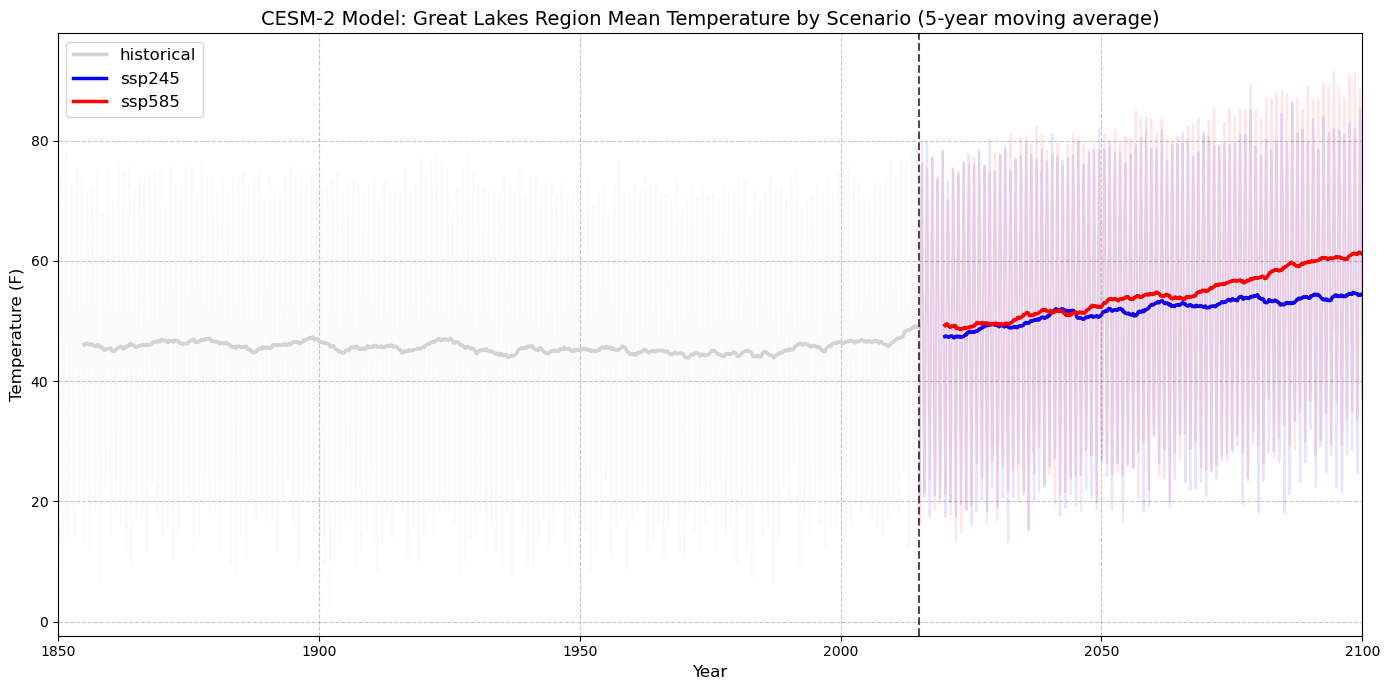

In [13]:
# Function to calculate running mean
def running_mean(data, window):
    return np.convolve(data, np.ones(window)/window, mode='valid')

# Create scenarios list
scenarios = ['historical', 'ssp245', 'ssp585']
colors = {'historical': 'lightgrey', 'ssp245': 'blue', 'ssp585': 'red'}

# Create a figure for the Great Lakes region with smoother curves
fig, ax = plt.subplots(figsize=(14, 7))

# Process and plot each scenario
for scenario in scenarios:
    # Create a mask for this scenario
    scenario_mask = cesm2_gl.scenario == scenario
    
    # Apply the mask to get data for this scenario only
    scenario_data = cesm2_gl.tas_fahrenheit.where(scenario_mask, drop=True)
    
    # Calculate regional mean (across lat/lon) for each time point
    regional_mean = scenario_data.mean(dim=['lat', 'lon']).compute()
    
    # Get the time values for this scenario
    time_values = cesm2_gl.time.where(scenario_mask, drop=True).values
    
    # Extract years as numeric values for plotting
    years = np.array([t.year + (t.month-1)/12 + t.day/365 for t in time_values])
    window_size = 60
    if len(regional_mean) > window_size:
        smoothed_data = running_mean(regional_mean.values, window_size)
        smoothed_years = years[window_size-1:]
        
        # Plot both the raw  and smoothed data
        ax.plot(years, regional_mean.values, color=colors[scenario], alpha=0.1)
        ax.plot(smoothed_years, smoothed_data, 
                color=colors[scenario], 
                linewidth=2.5,
                label=f"{scenario}")
    else:
        ax.plot(years, regional_mean.values, 
                color=colors[scenario], 
                linewidth=2.5,
                label=scenario)

# Add labels and title
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Temperature (F)', fontsize=12)
ax.set_title('CESM-2 Model: Great Lakes Region Mean Temperature by Scenario (5-year moving average)', fontsize=14)
ax.legend(fontsize=12)
ax.grid(True, linestyle='--', alpha=0.7)

# Set appropriate x-axis limits
plt.xlim(1850, 2100)

# Highlight the transition between historical and future periods (around 2015)
plt.axvline(x=2015, color='black', linestyle='--', alpha=0.7, 
            label='Historical to future transition')

# Show the plot
plt.tight_layout()
plt.show()

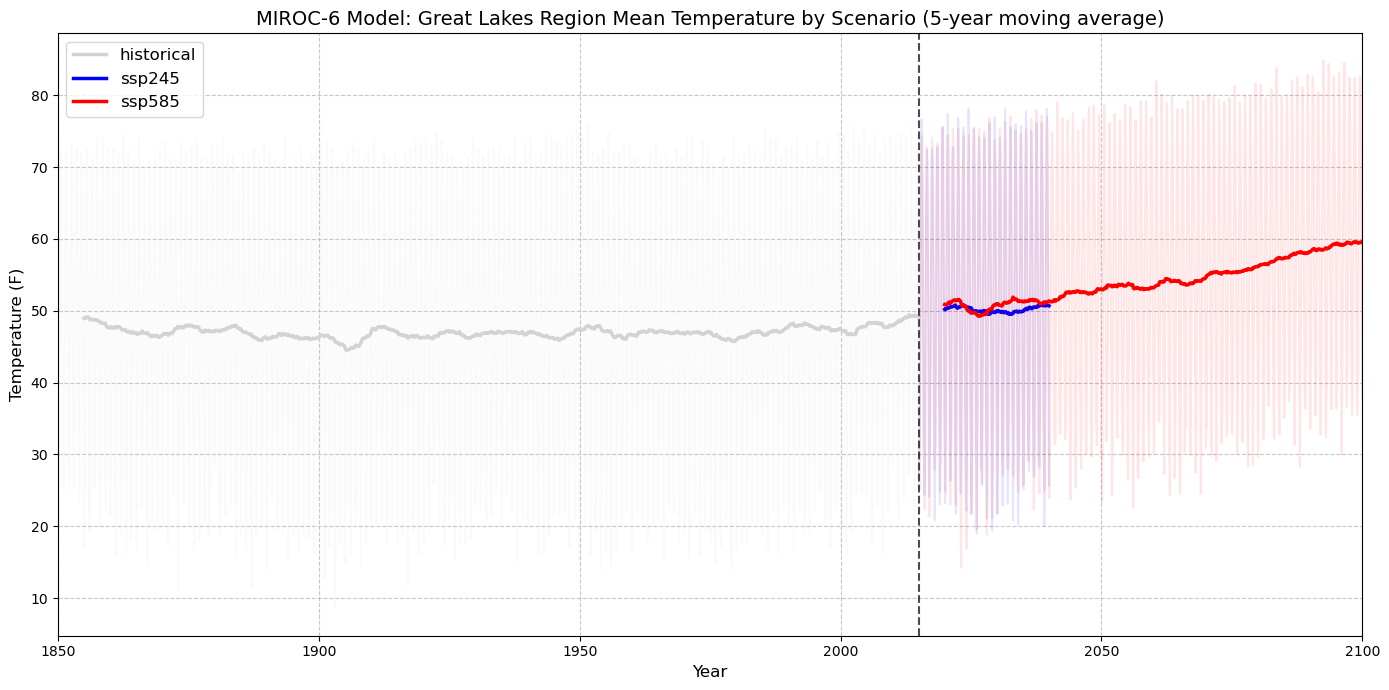

In [14]:
# Function to calculate running mean
def running_mean(data, window):
    return np.convolve(data, np.ones(window)/window, mode='valid')

# Create scenarios list
scenarios = ['historical', 'ssp245', 'ssp585']
colors = {'historical': 'lightgrey', 'ssp245': 'blue', 'ssp585': 'red'}

# Create a figure for the Great Lakes region with smoother curves
fig, ax = plt.subplots(figsize=(14, 7))

# Process and plot each scenario
for scenario in scenarios:
    # Create a mask for this scenario
    scenario_mask = miroc6_gl.scenario == scenario
    
    # Apply the mask to get data for this scenario only
    scenario_data = miroc6_gl.tas_fahrenheit.where(scenario_mask, drop=True)
    
    # Calculate regional mean (across lat/lon) for each time point
    regional_mean = scenario_data.mean(dim=['lat', 'lon']).compute()
    
    # Get the time values for this scenario
    time_values = miroc6_gl.time.where(scenario_mask, drop=True).values
    
    # Extract years as numeric values for plotting
    years = np.array([pd.Timestamp(t).year + 
                 (pd.Timestamp(t).month-1)/12 + 
                 pd.Timestamp(t).day/365 
                 for t in time_values])
    
    # Apply 5-year (60-month) moving average to smooth the data
    window_size = 60
    if len(regional_mean) > window_size:
        smoothed_data = running_mean(regional_mean.values, window_size)
        smoothed_years = years[window_size-1:]
        
        # Plot both the raw (transparent) and smoothed data
        ax.plot(years, regional_mean.values, color=colors[scenario], alpha=0.1)
        ax.plot(smoothed_years, smoothed_data, 
                color=colors[scenario], 
                linewidth=2.5,
                label=f"{scenario}")
    else:
        # If not enough data points for smoothing, just plot raw data
        ax.plot(years, regional_mean.values, 
                color=colors[scenario], 
                linewidth=2.5,
                label=scenario)

# Add labels and title
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Temperature (F)', fontsize=12)
ax.set_title('MIROC-6 Model: Great Lakes Region Mean Temperature by Scenario (5-year moving average)', fontsize=14)
ax.legend(fontsize=12)
ax.grid(True, linestyle='--', alpha=0.7)

# Set appropriate x-axis limits
plt.xlim(1850, 2100)

# Highlight the transition between historical and future periods (around 2015)
plt.axvline(x=2015, color='black', linestyle='--', alpha=0.7, 
            label='Historical to future transition')

# Show the plot
plt.tight_layout()
plt.show()

## Mann-Kendall Test
For all of the following historical and SSP scenarios for each model, we take the air temperature in Farenheit data that's clipped to the Great Lakes region and remove NAs. We then downsample the data by taking every 10th point to avoid memory issues. If we were to take every point, we would need 1.1TB of memory, which we do not have access to. Once the data is cleaned and downsampled, we run a Mann-Kendall test on it to determine the following:
- whether there's a trend
- direction of trend
- statistical signficance of trend


### CANESM-5

In [15]:
hist_canesm5_gl = canesm5_gl.where(canesm5_gl.scenario == "historical", drop = True)
hist_canesm5_gl_values = hist_canesm5_gl['tas_fahrenheit'].values
hist_canesm5_gl_clean = hist_canesm5_gl_values[~np.isnan(hist_canesm5_gl_values)]
hist_canesm5_downsampled = hist_canesm5_gl_clean[::10]
# Run the test
hist_canesm5_gl_result = mk.original_test(hist_canesm5_downsampled)
hist_canesm5_gl_result


Mann_Kendall_Test(trend='no trend', h=False, p=0.9970321437537595, z=-0.0037196647684041998, Tau=-2.7902461921908823e-05, s=-875.0, var_s=55209684179.0, slope=-4.6944937297084816e-07, intercept=45.90956218445048)

In [16]:
ssp245_canesm5_gl = canesm5_gl.where(canesm5_gl.scenario == "ssp245", drop = True)
ssp245_canesm5_gl_values = ssp245_canesm5_gl['tas_fahrenheit'].values
ssp245_canesm5_gl_clean = ssp245_canesm5_gl_values[~np.isnan(ssp245_canesm5_gl_values)]
ssp245_canesm5_downsampled = ssp245_canesm5_gl_clean[::10]

# Run the test
ssp245_canesm5_gl_result = mk.original_test(ssp245_canesm5_downsampled)
ssp245_canesm5_gl_result

Mann_Kendall_Test(trend='increasing', h=True, p=1.3330200943073578e-08, z=5.681777498631, Tau=0.058980447347116646, s=502403.0, var_s=7818695038.333333, slope=0.001888786385654223, intercept=49.114721119984736)

In [17]:
ssp585_canesm5_gl = canesm5_gl.where(canesm5_gl.scenario == "ssp585", drop = True)
ssp585_canesm5_gl_values = ssp585_canesm5_gl['tas_fahrenheit'].values
ssp585_canesm5_gl_clean = ssp585_canesm5_gl_values[~np.isnan(ssp585_canesm5_gl_values)]
ssp585_canesm5_downsampled = ssp585_canesm5_gl_clean[::10]
# Run the test
ssp585_canesm5_gl_result = mk.original_test(ssp585_canesm5_downsampled)
ssp585_canesm5_gl_result

Mann_Kendall_Test(trend='increasing', h=True, p=0.0, z=14.105601114997166, Tau=0.14642489523519722, s=1247266.0, var_s=7818695039.333333, slope=0.004746223126000505, intercept=46.47375814858975)

### CESM-2

In [18]:
hist_cesm2_gl = cesm2_gl.where(cesm2_gl.scenario == "historical", drop = True)
hist_cesm2_gl_values = hist_cesm2_gl['tas_fahrenheit'].values
hist_cesm2_gl_clean = hist_cesm2_gl_values[~np.isnan(hist_cesm2_gl_values)]
hist_cesm2_downsampled = hist_cesm2_gl_clean[::10]

# Run the test
hist_cesm2_gl_result = mk.original_test(hist_cesm2_downsampled)
hist_cesm2_gl_result

Mann_Kendall_Test(trend='no trend', h=False, p=0.7404657722130075, z=-0.33123660547324113, Tau=-0.0009279939982768862, s=-1487887.0, var_s=20177282014405.0, slope=-1.926518622695667e-06, intercept=47.30060399539967)

In [19]:
ssp245_cesm2_gl = cesm2_gl.where(cesm2_gl.scenario == "ssp245", drop = True)
ssp245_cesm2_gl_values = ssp245_cesm2_gl['tas_fahrenheit'].values
ssp245_cesm2_gl_clean = ssp245_cesm2_gl_values[~np.isnan(ssp245_cesm2_gl_values)]
ssp245_cesm2_downsampled = ssp245_cesm2_gl_clean[::10]
# Run the test
ssp245_cesm2_gl_result = mk.original_test(ssp245_cesm2_downsampled)
ssp245_cesm2_gl_result

Mann_Kendall_Test(trend='increasing', h=True, p=0.0, z=15.883163512499516, Tau=0.06163718012737752, s=26848069.0, var_s=2857275152761.6665, slope=0.0002383449075649391, intercept=49.435091991332094)

In [20]:
ssp585_cesm2_gl = cesm2_gl.where(cesm2_gl.scenario == "ssp585", drop = True)
ssp585_cesm2_gl_values = ssp585_cesm2_gl['tas_fahrenheit'].values
ssp585_cesm2_gl_clean = ssp585_cesm2_gl_values[~np.isnan(ssp585_cesm2_gl_values)]
ssp585_cesm2_downsampled = ssp585_cesm2_gl_clean[::10]
# Run the test
ssp585_cesm2_gl_result = mk.original_test(ssp585_cesm2_downsampled)
ssp585_cesm2_gl_result

Mann_Kendall_Test(trend='increasing', h=True, p=0.0, z=30.665552868658633, Tau=0.11900262630004975, s=51835446.0, var_s=2857275152781.3335, slope=0.00046670571694579796, intercept=48.64744908578567)

### MIROC-6

In [21]:
hist_miroc6_gl = miroc6_gl.where(miroc6_gl.scenario == "historical", drop = True)
hist_miroc6_gl_values = hist_miroc6_gl['tas_fahrenheit'].values
hist_miroc6_gl_clean = hist_miroc6_gl_values[~np.isnan(hist_miroc6_gl_values)]
hist_miroc6_downsampled = hist_miroc6_gl_clean[::10]
# Run the test
hist_miroc6_gl_result = mk.original_test(hist_miroc6_downsampled)
hist_miroc6_gl_result

Mann_Kendall_Test(trend='no trend', h=False, p=0.2021414512238211, z=1.275474197521337, Tau=0.004901753608699158, s=2219855.0, var_s=3029043211072.3335, slope=1.6612230147790043e-05, intercept=48.995459366875544)

In [22]:
ssp245_miroc6_gl = miroc6_gl.where(miroc6_gl.scenario == "ssp245", drop = True)
ssp245_miroc6_gl_values = ssp245_miroc6_gl['tas_fahrenheit'].values
ssp245_miroc6_gl_clean = ssp245_miroc6_gl_values[~np.isnan(ssp245_miroc6_gl_values)]
ssp245_miroc6_downsampled = ssp245_miroc6_gl_clean[::10]
# Run the test
ssp245_miroc6_gl_result = mk.original_test(ssp245_miroc6_downsampled)
ssp245_miroc6_gl_result

Mann_Kendall_Test(trend='no trend', h=False, p=0.4752789144311542, z=0.713916337272493, Tau=0.007050926834524345, s=73291.0, var_s=10538888322.333334, slope=0.00015636510168851535, intercept=51.66974601803501)

In [23]:
ssp585_miroc6_gl = miroc6_gl.where(miroc6_gl.scenario == "ssp585", drop = True)
ssp585_miroc6_gl_values = ssp585_miroc6_gl['tas_fahrenheit'].values
ssp585_miroc6_gl_clean = ssp585_miroc6_gl_values[~np.isnan(ssp585_miroc6_gl_values)]
ssp585_miroc6_downsampled = ssp585_miroc6_gl_clean[::10]
# Run the test
ssp585_miroc6_gl_result = mk.original_test(ssp585_miroc6_downsampled)
ssp585_miroc6_gl_result

Mann_Kendall_Test(trend='increasing', h=True, p=0.0, z=18.874945758838432, Tau=0.10047846376611648, s=12362181.0, var_s=428961881167.0, slope=0.0006329472830218356, intercept=50.59866829959177)